In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.filters import meijering, sato, frangi, hessian
from skimage.measure import label, regionprops
from sklearn import decomposition
from scipy.ndimage import gaussian_filter

In [2]:
im = Image.open('SCANS/F20_10_b/6um_jamtveit_att_pag-1.99_3-10000.tif')
imarr = np.array(im)

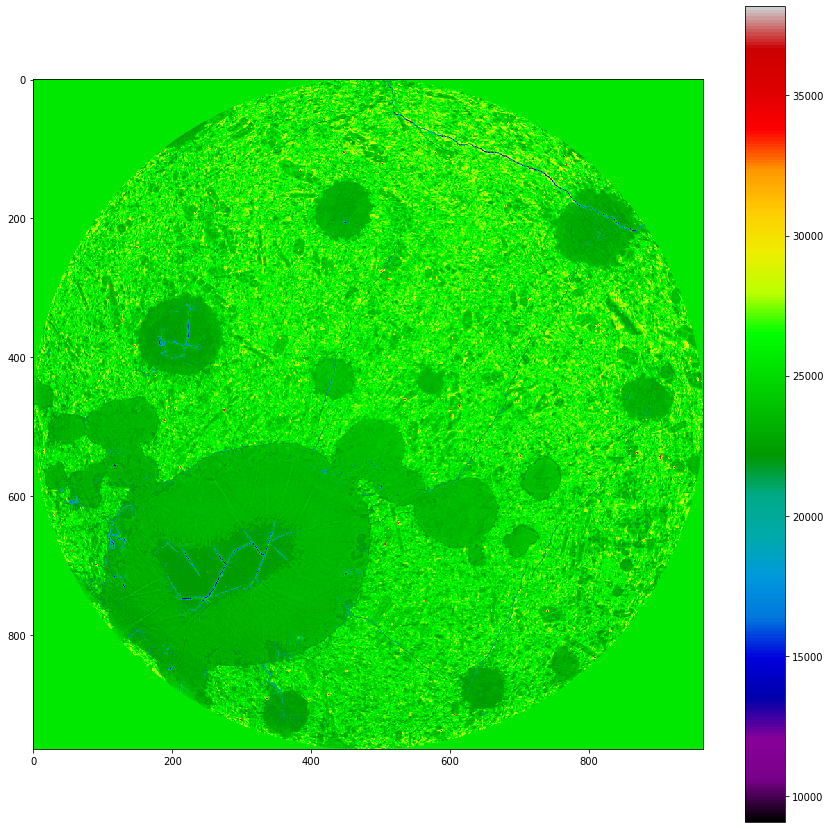

In [3]:
fig, ax = plt.subplots(figsize=(15, 15))
cbar = ax.imshow(imarr, cmap='nipy_spectral')
fig.colorbar(cbar)

In [4]:
# value, counts = np.unique(imarr, return_counts=True)
# histdf = pd.DataFrame({'value':value, 'counts':counts}).sort_values(by='value')

# fig, ax = plt.subplots()
# histdf.plot(x='value', y='counts', ax=ax)
# ax.set_yscale('log')

In [5]:
imarr_blur = gaussian_filter(imarr, sigma=1)

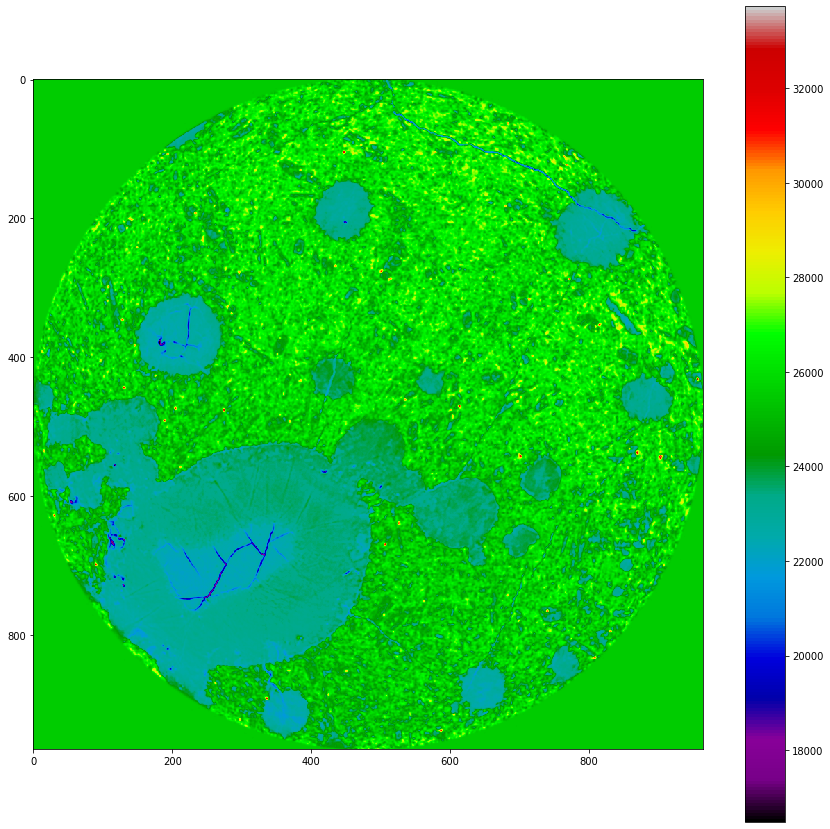

In [6]:
fig, ax = plt.subplots(figsize=(15, 15))
cbar = ax.imshow(imarr_blur, cmap='nipy_spectral')
fig.colorbar(cbar)

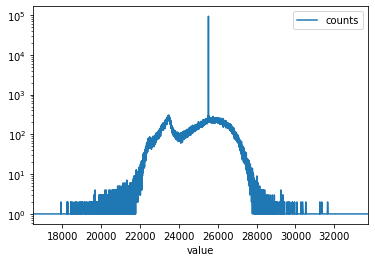

In [7]:
# value, counts = np.unique(imarr_blur, return_counts=True)
# histdf = pd.DataFrame({'value':value, 'counts':counts}).sort_values(by='value')

# fig, ax = plt.subplots()
# histdf.plot(x='value', y='counts', ax=ax)
# ax.set_yscale('log')

In [8]:
# nanvals = histdf[histdf.counts > 1e3]['value'].values

In [9]:
# imarr_mask = np.where(np.isin(imarr_blur, nanvals), np.nan, imarr_blur)

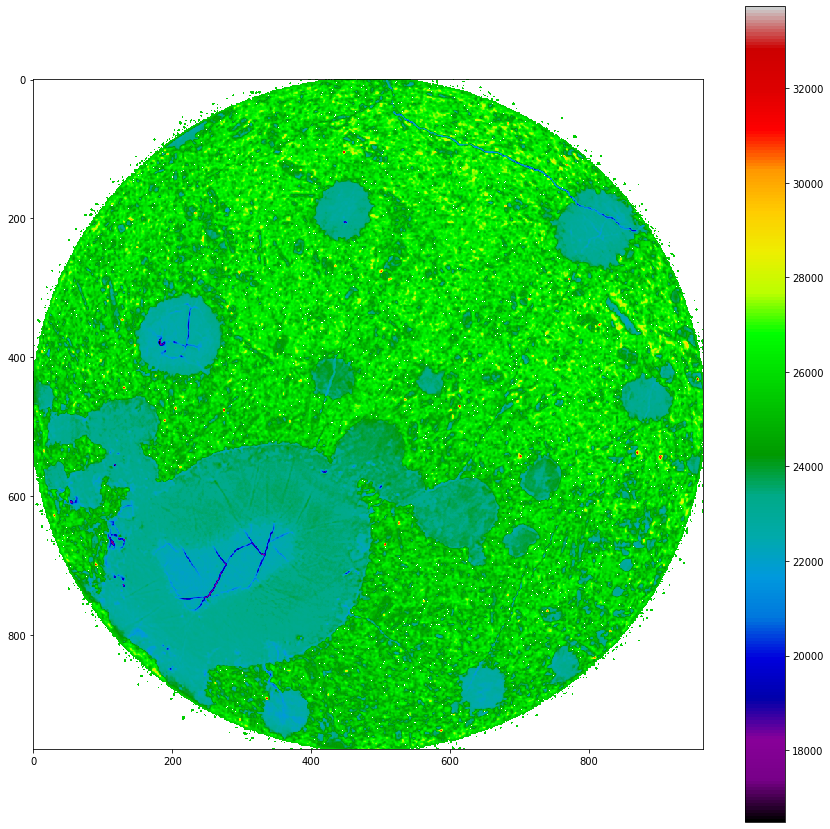

In [10]:
# fig, ax = plt.subplots(figsize=(15, 15))
# cbar = ax.imshow(imarr_mask, cmap='nipy_spectral')
# fig.colorbar(cbar)

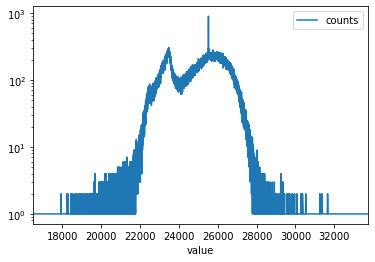

In [11]:
# value, counts = np.unique(imarr_mask, return_counts=True)
# histdf = pd.DataFrame({'value':value, 'counts':counts}).sort_values(by='value')

# fig, ax = plt.subplots()
# histdf.plot(x='value', y='counts', ax=ax)
# ax.set_yscale('log')

In [13]:
# imarr.shape

(965, 965)

In [19]:
"""
creates a mask based on the radius of the sample to remove
outlying data in the scan which is meaningless and not part
of the sample
"""

x = np.arange(imarr.shape[0])
y = np.arange(imarr.shape[1])

cx = imarr.shape[0] // 2
cy = imarr.shape[1] // 2
r = imarr.shape[0] // 2

mask = (x[np.newaxis,:] - cx)**2 + (y[:, np.newaxis] - cy)**2 > r**2

imarr_maskradius = imarr.astype(np.float64)
imarr_maskradius[mask] = np.nan 

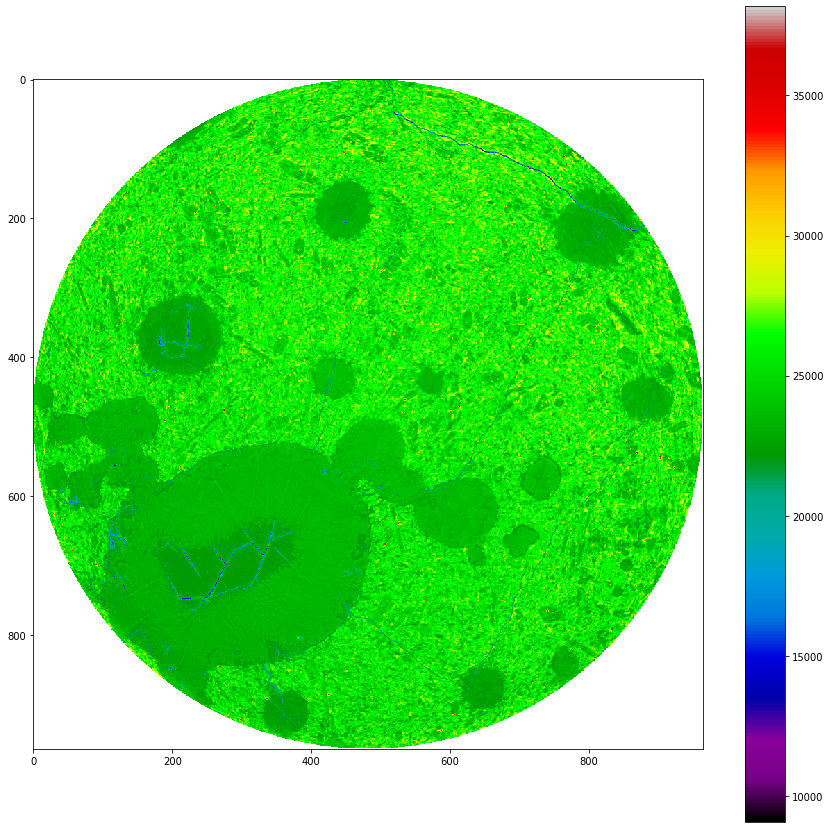

In [20]:
fig, ax = plt.subplots(figsize=(15, 15))
cbar = ax.imshow(imarr_maskradius, cmap='nipy_spectral')
fig.colorbar(cbar)

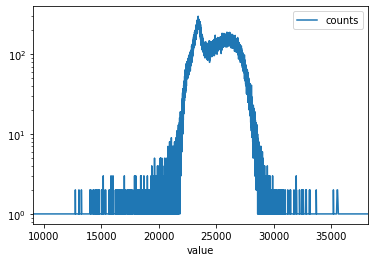

In [21]:
value, counts = np.unique(imarr_maskradius, return_counts=True)
histdf = pd.DataFrame({'value':value, 'counts':counts}).sort_values(by='value')

fig, ax = plt.subplots()
histdf.plot(x='value', y='counts', ax=ax)
ax.set_yscale('log')

In [22]:
imarr_blur = gaussian_filter(imarr_maskradius, sigma=1)

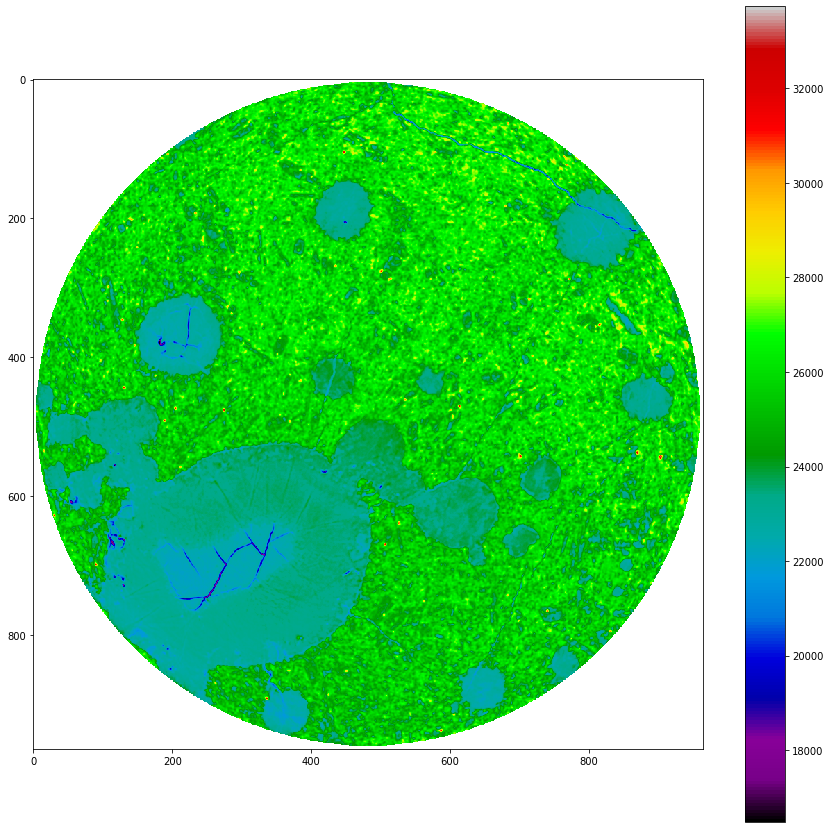

In [23]:
fig, ax = plt.subplots(figsize=(15, 15))
cbar = ax.imshow(imarr_blur, cmap='nipy_spectral')
fig.colorbar(cbar)

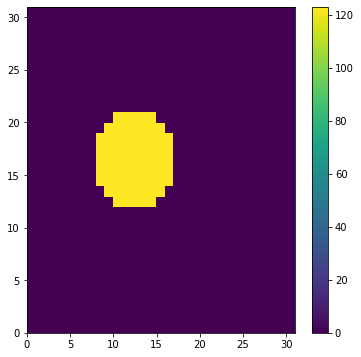

In [14]:
# x = np.arange(0, 32)
# y = np.arange(0, 32)
# arr = np.zeros((y.size, x.size))

# cx = 12.
# cy = 16.
# r = 5.

# # The two lines below could be merged, but I stored the mask
# # for code clarity.
# mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < r**2
# arr[mask] = 123.

# # This plot shows that only within the circle the value is set to 123.
# plt.figure(figsize=(6, 6))
# plt.pcolormesh(x, y, arr)
# plt.colorbar()
# plt.show()